## Introduction

This notebook is the second step after running insitu_GWSA_temporal_demo or insitu_GWLA_temporal_demo.

The outcome is Pearson r between all G3P products against in-situ data and the graphs comparing them.

In [1]:
#Istall all packages needed for this notebook. 
#Follow this website to install geopandas
#https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b
from scipy.io import netcdf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import regionmask
import geopandas as gpd
import warnings; warnings.filterwarnings(action='ignore')
import cartopy.crs as ccrs
import pooch

## 1. Read the latest G3P version.

If the period of study is different from the period of G3P, import the recalculated G3P .nc files:

Read all three products: GWSA, GWSA_LA_hyd, GWSA_LA_grav

In [2]:
#For the analysis read the latest G3P version - in this case v1.5
import xarray as xr
g3p = xr.open_mfdataset('G3P_GWSA_V1.5_0.5deg_M_200204_202012.nc', combine='nested', concat_dim='time', parallel=True)
g3p_GWSA = xr.open_mfdataset('G3P_GWSA_V1.5_0.5deg_M_200204_202012_mean_base_2002_2016.nc', combine='nested', concat_dim='time', parallel=True)
g3p_LAgrav = xr.open_mfdataset('G3P_GWSA_LA_grav_V1.5_0.5deg_M_200204_202012_mean_base_2002_2016.nc', combine='nested', concat_dim='time', parallel=True)
g3p_LAhyd = xr.open_mfdataset('G3P_GWSA_LA_hyd_V1.5_0.5deg_M_200204_202012_mean_base_2002_2016.nc', combine='nested', concat_dim='time', parallel=True)

## 2. Read .shp file of polygon that contains the boreholes - either the aquifer shp or the polygon within the aquifer shp

PLot both data

In [3]:
PATH_TO_SHAPEFILE = './shp_demo/alternative_area_50x50.shp'
shp = gpd.read_file(PATH_TO_SHAPEFILE)
shp.head()

,id,FID,area_m2,geometry
0,1,156,8.308522e+10,"MULTIPOLYGON (((-99.42503 42.50064, -99.43552 ..."


In [4]:
#convert to wgs84 coordinate system
shp_wgs = shp.to_crs(epsg=4326)

<Figure size 1080x576 with 0 Axes>

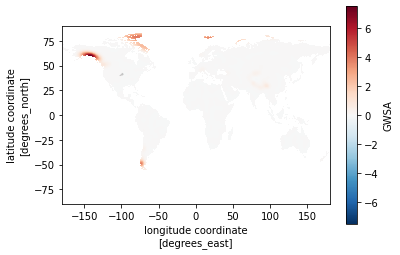

In [5]:
#plot both the aquifer and the g3p
plt.figure(figsize=(15,8))
ax = shp_wgs.plot(alpha=0.2, color='black')
g3p.GWSA.mean(dim="time").plot(ax=ax,zorder=-1)

## 3. Clip .nc file into given .shp and generate area-average G3P GWSA 

In [6]:
import rioxarray
from shapely.geometry import mapping
df_GWSA = pd.DataFrame()
#Put .nc into correct format
GWSA = g3p_GWSA
GWSA.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
GWSA.rio.write_crs("epsg:4326", inplace=True)

GWSA_LAhyd = g3p_LAhyd
GWSA_LAhyd.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
GWSA_LAhyd.rio.write_crs("epsg:4326", inplace=True)

GWSA_LAgrav = g3p_LAgrav
GWSA_LAgrav.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
GWSA_LAgrav.rio.write_crs("epsg:4326", inplace=True)

uncertainty = g3p
uncertainty.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
uncertainty.rio.write_crs("epsg:4326", inplace=True)
#Clip .nc with .shp of polygon
clipped_GWSA = GWSA.rio.clip(shp_wgs.geometry.apply(mapping), shp_wgs.crs, drop=False)
clipped_LAhyd = GWSA_LAhyd.rio.clip(shp_wgs.geometry.apply(mapping), shp_wgs.crs, drop=False)
clipped_LAgrav = GWSA_LAgrav.rio.clip(shp_wgs.geometry.apply(mapping), shp_wgs.crs, drop=False)
clipped_uncertainty = uncertainty.rio.clip(shp_wgs.geometry.apply(mapping), shp_wgs.crs, drop=False)
#Generate area-average time series
y1 = clipped_GWSA.groupby('time').mean(...)
y2 = clipped_LAhyd.groupby('time').mean(...)
y3 = clipped_LAgrav.groupby('time').mean(...)
y4 = clipped_uncertainty.groupby('time').mean(...)
#Put everything together in a dataframe
df_GWSA['GWSA'] = pd.DataFrame(y1.GWSA.to_dataframe()['GWSA'])
df_GWSA['GWSA_LAhyd'] = pd.DataFrame(y2.GWSA_LA_hyd.to_dataframe()['GWSA_LA_hyd'])
df_GWSA['GWSA_LAgrav'] = pd.DataFrame(y3.GWSA_LA_grav.to_dataframe()['GWSA_LA_grav'])
df_GWSA['uncertainty'] = pd.DataFrame(y4.uncertainty.to_dataframe()['uncertainty'])

In [7]:
df_GWSA.head()

,GWSA,GWSA_LAhyd,GWSA_LAgrav,uncertainty
time,,,,
2002-04-01,63.619404,50.732525,81.083886,31.789883
2002-05-01,63.245839,44.810560,129.371835,26.352091
2002-08-01,21.340382,2.869733,61.930979,22.310405
2002-09-01,-7.847296,-22.302272,-29.640157,25.101244
2002-10-01,-6.779780,-15.626534,-24.092504,19.317339


In [8]:
##RESAMPLE TO OBTAIN NAN months
aux_df = df_GWSA.copy()
aux_df = aux_df.resample('M').mean()
aux_df.head()

,GWSA,GWSA_LAhyd,GWSA_LAgrav,uncertainty
time,,,,
2002-04-30,63.619404,50.732525,81.083886,31.789883
2002-05-31,63.245839,44.810560,129.371835,26.352091
2002-06-30,NaN,NaN,NaN,NaN
2002-07-31,NaN,NaN,NaN,NaN
2002-08-31,21.340382,2.869733,61.930979,22.310405


Text(0, 0.5, 'G3P GWSA [mm]')

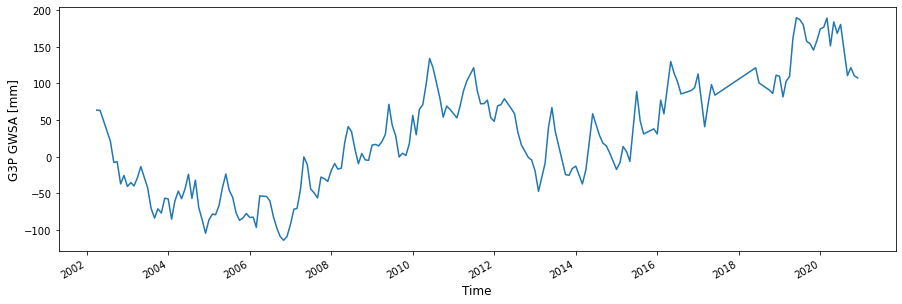

In [9]:
# Plot resulting data
f,ax=plt.subplots(figsize=(15,5))
df_GWSA.GWSA.plot()#y='GWSA', ax=ax, label='G3P').resample('1Y').mean()
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('G3P GWSA [mm]', fontsize = 12)

## 4. Bring in-situ data from previous step

In [10]:
#BRING IN-SITU TIME SERIES
insitu_df = pd.read_excel('longdf_alldata_2002_2016_demo.xlsx')
insitu_df

,Unnamed: 0,SiteNo_1,date,water_level,sy*area,confined/unconfined,mean_waterlevel,meandiff_gwl,gws_m3,gws_mm
0,0,400155101521302,2002-01-31,6.518295,2.308793e+09,UNCONFINED,6.340397,-0.177898,-4.107300e+08,-4.943479
1,1,400155101521302,2002-02-28,6.545580,2.308793e+09,UNCONFINED,6.340397,-0.205183,-4.737243e+08,-5.701668
2,2,400155101521302,2002-03-31,6.433769,2.308793e+09,UNCONFINED,6.340397,-0.093372,-2.155763e+08,-2.594641
3,3,400155101521302,2002-04-30,6.840658,2.308793e+09,UNCONFINED,6.340397,-0.500261,-1.154998e+09,-13.901367
4,4,400155101521302,2002-05-31,7.519975,2.308793e+09,UNCONFINED,6.340397,-1.179577,-2.723400e+09,-32.778395
...,...,...,...,...,...,...,...,...,...,...
3775,3775,423730098560001,2016-08-31,11.283794,5.906996e+08,UNCONFINED,11.672108,0.388313,2.293766e+08,2.760739
3776,3776,423730098560001,2016-09-30,11.335614,5.906996e+08,UNCONFINED,11.672108,0.336494,1.987670e+08,2.392327
3777,3777,423730098560001,2016-10-31,11.212412,5.906996e+08,UNCONFINED,11.672108,0.459696,2.715420e+08,3.268235
3778,3778,423730098560001,2016-11-30,11.126216,5.906996e+08,UNCONFINED,11.672108,0.545892,3.224581e+08,3.881052


## 5. Generate the area-average in-situ time series

 - **To generate in-situ GWSA** --> Perform the .sum at the end of the first line, with the attribute "gws_mm":
      
      insitu_df1 = insitu_df[['date', 'gws_mm']].groupby('date', as_index=False).sum()
     
     
     
 - **To generate in-situ GWLA** --> Perform the .mean at the end of the first line, with the attribute "meandiff_gwl"
 
     insitu_df1 = insitu_df[['date', 'meandiff_gwl']].groupby('date', as_index=False).mean()    
     

,gws_mm
date,
2002-01-31,57.841144
2002-02-28,57.423253
2002-03-31,66.747575
2002-04-30,53.166157
2002-05-31,30.795582
...,...
2016-08-31,-10.254054
2016-09-30,-9.659494
2016-10-31,17.172120


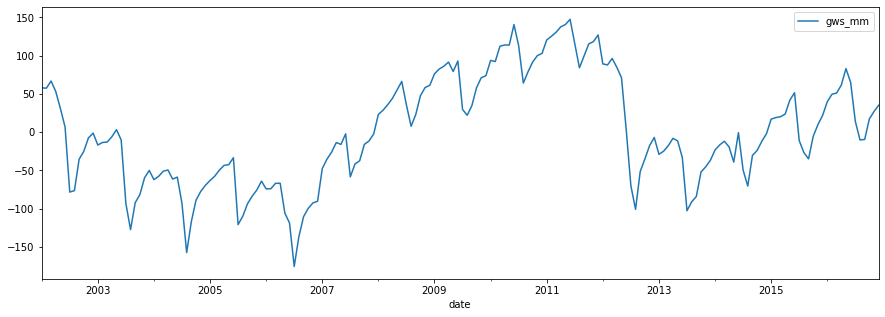

In [11]:
# Transform the data of all boreholes into a single time series of storage/level anomalies
insitu_df1 = insitu_df[['date', 'gws_mm']].groupby('date', as_index=False).sum() #Generate GWSA in this case
insitu_df1.set_index('date', inplace=True)
plt.figure(figsize=(15,5))
ax = plt.axes()
insitu_df1.plot(ax=ax)
insitu_df1

## 6. Perform comparison of in-situ GWSA/GWLA and G3P

Join in-situ GWSA/GWLA and G3P data into one dataframe

In [12]:
stats_df = aux_df['2002-01-01':'2016-12-31'].join(insitu_df1)
stats_df

,GWSA,GWSA_LAhyd,GWSA_LAgrav,uncertainty,gws_mm
time,,,,,
2002-04-30,63.619404,50.732525,81.083886,31.789883,53.166157
2002-05-31,63.245839,44.810560,129.371835,26.352091,30.795582
2002-06-30,NaN,NaN,NaN,NaN,6.498942
2002-07-31,NaN,NaN,NaN,NaN,-78.453508
2002-08-31,21.340382,2.869733,61.930979,22.310405,-76.574631
...,...,...,...,...,...
2016-08-31,85.660791,76.835397,19.316739,19.233785,-10.254054
2016-09-30,NaN,NaN,NaN,NaN,-9.659494
2016-10-31,NaN,NaN,NaN,NaN,17.172120


Run Pearson correlation and respective p-value per parameter

In [13]:
import scipy.stats as stats
r, p = stats.pearsonr(stats_df.dropna().GWSA, stats_df.dropna().gws_mm)
s, t = stats.pearsonr(stats_df.dropna().GWSA_LAgrav, stats_df.dropna().gws_mm)
u, v = stats.pearsonr(stats_df.dropna().GWSA_LAhyd, stats_df.dropna().gws_mm)
print(f"Scipy computed Pearson r for GWSA: {r} and p-value: {p}")
print(f"Scipy computed Pearson r for GWSA_LA_grav: {s} and p-value: {t}")
print(f"Scipy computed Pearson r for GWSA_LA_hyd: {u} and p-value: {v}")

Scipy computed Pearson r for GWSA: 0.765951370463715 and p-value: 9.745018365188592e-32
Scipy computed Pearson r for GWSA_LA_grav: 0.5195763398066033 and p-value: 2.648185726694563e-12
Scipy computed Pearson r for GWSA_LA_hyd: 0.792744182714212 and p-value: 2.3221608526057068e-35


## 7. Plot results

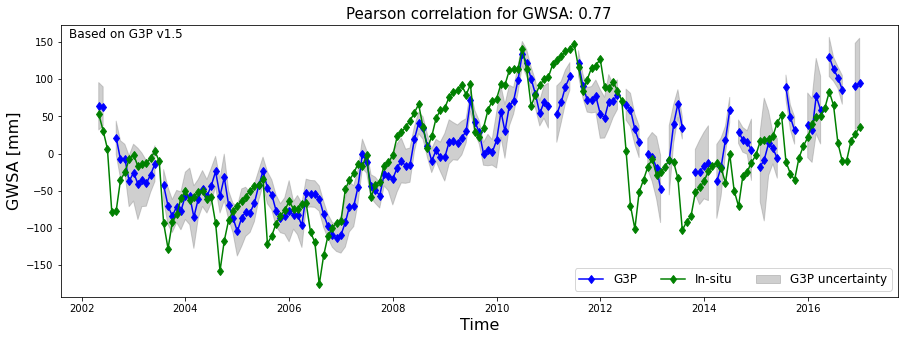

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

ax1.plot(stats_df.GWSA, c='b', marker="d", label='G3P')
ax1.plot(stats_df.gws_mm, c='green', marker="d", label='In-situ')
ax1.fill_between(stats_df.GWSA.reset_index().time, stats_df.GWSA - stats_df.uncertainty, stats_df.GWSA + stats_df.uncertainty, color='#888888', alpha=0.4, label='G3P uncertainty')
ax1.text(.01, .99, 'Based on G3P v1.5', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_xlabel('Time', fontsize = 16)
ax1.set_ylabel('GWSA [mm]', fontsize = 16)
plt.legend(loc='lower right', fontsize = 12, ncol=3);
plt.title(label="Pearson correlation for GWSA: 0.77", #change here if correlation value changes
          fontsize=15,
          color="k")
plt.show()

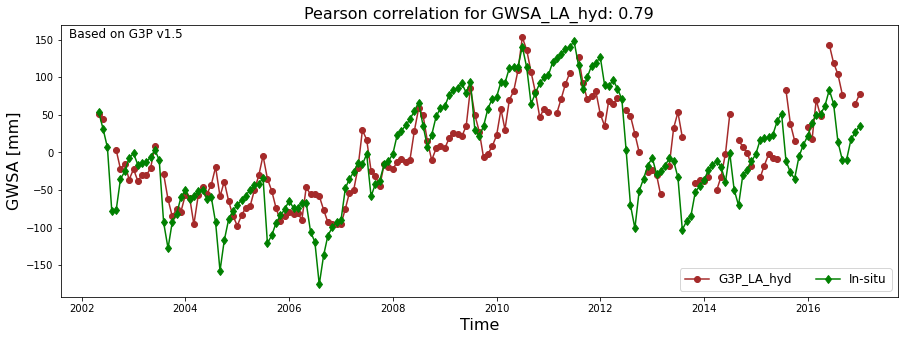

In [15]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

ax1.plot(stats_df.GWSA_LAhyd, c='brown', marker="o", label='G3P_LA_hyd')
ax1.plot(stats_df.gws_mm, c='g', marker="d", label='In-situ')
ax1.text(.01, .99, 'Based on G3P v1.5', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_xlabel('Time', fontsize = 16)
ax1.set_ylabel('GWSA [mm]', fontsize = 16)
plt.legend(loc='lower right', fontsize = 12, ncol=2);
plt.title(label="Pearson correlation for GWSA_LA_hyd: 0.79",#change here if correlation value changes
          fontsize=16,
          color="k")
plt.show()

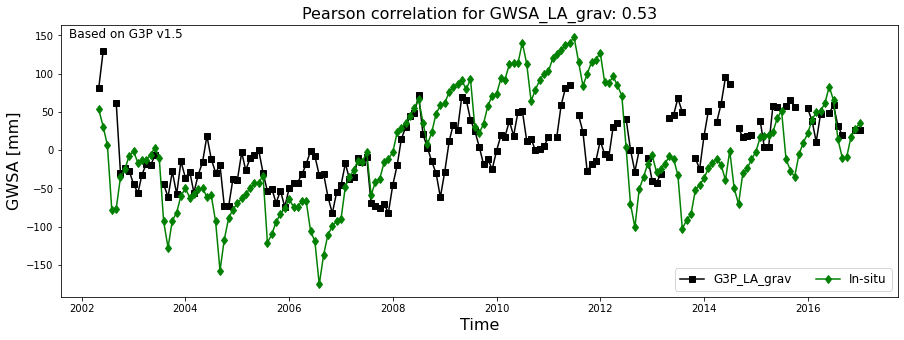

In [16]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

ax1.plot(stats_df.GWSA_LAgrav, c='k', marker="s", label='G3P_LA_grav')
ax1.plot(stats_df.gws_mm, c='g', marker="d", label='In-situ') 
ax1.text(.01, .99, 'Based on G3P v1.5', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax1.set_xlabel('Time', fontsize = 16)
ax1.set_ylabel('GWSA [mm]', fontsize = 16)
plt.legend(loc='lower right', fontsize = 12, ncol=2);
plt.title(label="Pearson correlation for GWSA_LA_grav: 0.53",#change here if correlation value changes
          fontsize=16,
          color="k")
plt.show()

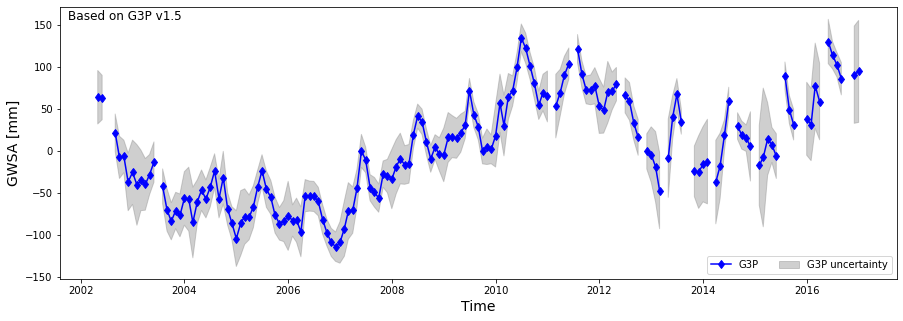

In [17]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

ax1.plot(stats_df.GWSA, c='b', marker="d", label='G3P')
ax1.fill_between(stats_df.GWSA.reset_index().time, stats_df.GWSA - stats_df.uncertainty, stats_df.GWSA + stats_df.uncertainty, color='#888888', alpha=0.4, label='G3P uncertainty')
ax1.set_xlabel('Time', fontsize = 14)
ax1.set_ylabel('GWSA [mm]', fontsize = 14)
ax1.text(.01, .99, 'Based on G3P v1.5', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
plt.legend(loc='lower right', ncol = 2);
plt.show()